# Classification with Logistic Regression

## Multiple Linear Regression

### The Titanic dataset
Consider for example dataset from https://www.kaggle.com/c/titanic/ 


In [76]:
import pandas as pd
# On colab use direct link
# raw = pd.read_csv("https://raw.githubusercontent.com/gbdrt/2025-m2-idl/refs/heads/main/4-classification/titanic.csv")
raw = pd.read_csv("titanic.csv")

# Prepare all features
df = raw.loc[:,["Survived"]].copy()
df["Pclass"] = raw["Pclass"]
df["Sex"] = raw["Sex"].apply(lambda s: 0 if s == "male" else 1)
df["Age"] = raw["Age"].fillna(raw["Age"].median())
df["SibSp"] = raw["SibSp"]
df["Parch"] = raw["Parch"]
df["Fare"] = raw["Fare"].fillna(raw["Fare"].median())

df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000
887,1,1,1,19.0,0,0,30.0000
888,0,3,1,28.0,1,2,23.4500
889,1,1,0,26.0,0,0,30.0000



We can use torch `Dataset` class to create a dataset and a test/train split on these data.

In [77]:

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn


class TitanicDataset(Dataset):
    def __init__(self, df):
        # Store feature names
        self.feature_names = [col for col in df.columns if col != "Survived"]
        
        # Convert to tensors
        self.X = torch.tensor(df[self.feature_names].values, dtype=torch.float64)
        self.y = torch.tensor(df["Survived"].values, dtype=torch.float64)
        
        # Normalize features
        self.X_mean = self.X.mean(dim=0)
        self.X_std = self.X.std(dim=0)
        self.X = (self.X - self.X_mean) / self.X_std
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset
dataset = TitanicDataset(df)

print(f"Features: {dataset.feature_names}")
print(f"Dataset size: {len(dataset)}")
print(f"Sample: {dataset[0]}")

Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Dataset size: 891
Sample: (tensor([ 0.8269, -0.7373, -0.5654,  0.4326, -0.4734, -0.5022],
       dtype=torch.float64), tensor(0., dtype=torch.float64))


In [78]:
from torch.utils.data import random_split, DataLoader

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Total samples: {len(dataset)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Get feature names and normalization params from dataset
feature_names = dataset.feature_names
X_mean = dataset.X_mean
X_std = dataset.X_std

Total samples: 891
Train samples: 712
Test samples: 179
Batch size: 32
Train batches: 23
Test batches: 6


You can try to play with the data. 
For instance here is a plot of the Fare for each age on the train set.

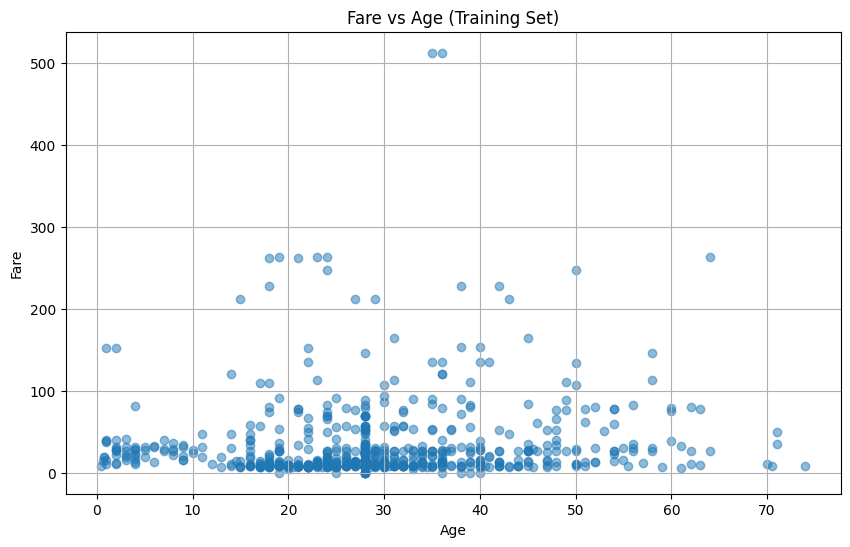

In [79]:
# Get Age and Fare indices
age_idx = dataset.feature_names.index("Age")
fare_idx = dataset.feature_names.index("Fare")

# Extract full training data for visualization
X_train_full = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Extract Age and Fare from training set (denormalize for plotting)
age_train = X_train_full[:, age_idx] * X_std[age_idx] + X_mean[age_idx]
fare_train = X_train_full[:, fare_idx] * X_std[fare_idx] + X_mean[fare_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(age_train, fare_train, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Fare vs Age (Training Set)')
plt.grid(True)
plt.show()

There is no clear correlation. 
So let's try something different : try to predict the Fare using all the other features.

In [80]:
# For linear regression, we predict Fare from all other features
# Get Fare index
fare_idx = dataset.feature_names.index("Fare")

# All features except Fare
linear_feature_names = [f for f in dataset.feature_names if f != "Fare"]
linear_indices = [dataset.feature_names.index(f) for f in linear_feature_names]

print(f"Linear regression features: {linear_feature_names}")
print(f"Target: Fare")
print(f"Number of features: {len(linear_feature_names)}")

Linear regression features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
Target: Fare
Number of features: 5


### Multiple inputs

Compared to a classic linear regression with one input, one output. We now have multiple inputs.

The simplest possible model is to learn **Linear combination** of the inputs:
$$
\hat{y} = w_{\text{Pclass}} \cdot x_{\text{Pclass}} + w_{\text{Sex}} \cdot x_{\text{Sex}} + w_{\text{Age}} \cdot x_{\text{Age}} + w_{\text{SibSp}} \cdot x_{\text{SibSp}} + w_{\text{Parch}} \cdot x_{\text{Parch}} + b
$$

Or in compact matrix form:
$$
\hat{y} = w^T x + b
$$

where $x \in \mathbb{R}^{5}$ is the feature vector (all features except Fare), $w \in \mathbb{R}^{5}$ is the weight vector, and $b \in \mathbb{R}$ is the bias.

This is a simple generalization of the classic linear regression. Notice that the formula in matrix (vectorized) form is actually really close.

In [81]:
# Initialize parameters for linear regression
num_linear_features = len(linear_feature_names)
w_linear = torch.zeros(num_linear_features, requires_grad=True, dtype=torch.float64)
b_linear = torch.zeros(1, requires_grad=True, dtype=torch.float64)

# Linear model
def linear_model(X):
    return X @ w_linear + b_linear

We can now train using a gradient descent.

In [82]:
# MSE loss
loss_fn_linear = nn.MSELoss()

# Training
learning_rate = 0.01  # Lower learning rate for mini-batch
num_epochs = 100
train_losses_linear = []
test_losses_linear = []

for epoch in range(num_epochs):
    # Training phase
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Extract features and target
        X_batch_linear = X_batch[:, linear_indices]
        y_batch_linear = X_batch[:, fare_idx]
        
        # Forward pass
        y_pred = linear_model(X_batch_linear)
        loss = loss_fn_linear(y_pred, y_batch_linear)
        
        # Backward pass
        loss.backward()
        
        # Update parameters (gradient descent step per batch)
        with torch.no_grad():
            w_linear -= learning_rate * w_linear.grad
            b_linear -= learning_rate * b_linear.grad
            w_linear.grad.zero_()
            b_linear.grad.zero_()
        
        epoch_train_loss += loss.item() * len(X_batch)
    
    # Average train loss for epoch
    avg_train_loss = epoch_train_loss / len(train_dataset)
    train_losses_linear.append(avg_train_loss)
    
    # Evaluation phase
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch_linear = X_batch[:, linear_indices]
            y_batch_linear = X_batch[:, fare_idx]
            
            y_pred = linear_model(X_batch_linear)
            loss = loss_fn_linear(y_pred, y_batch_linear)
            epoch_test_loss += loss.item() * len(X_batch)
    
    avg_test_loss = epoch_test_loss / len(test_dataset)
    test_losses_linear.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print(f"\nFinal train loss: {train_losses_linear[-1]:.4f}")
print(f"Final test loss: {test_losses_linear[-1]:.4f}")
print(f"\nLearned parameters:")
for i, feature in enumerate(linear_feature_names):
    print(f"  a_{feature}: {w_linear[i].item():>7.4f}")
print(f"  b:        {b_linear.item():>7.4f}")

Epoch 10/100, Train Loss: 0.6077, Test Loss: 0.7249
Epoch 20/100, Train Loss: 0.6067, Test Loss: 0.7276
Epoch 30/100, Train Loss: 0.6071, Test Loss: 0.7200
Epoch 40/100, Train Loss: 0.6069, Test Loss: 0.7207
Epoch 50/100, Train Loss: 0.6061, Test Loss: 0.7253
Epoch 60/100, Train Loss: 0.6064, Test Loss: 0.7210
Epoch 70/100, Train Loss: 0.6065, Test Loss: 0.7217
Epoch 80/100, Train Loss: 0.6073, Test Loss: 0.7210
Epoch 90/100, Train Loss: 0.6070, Test Loss: 0.7203
Epoch 100/100, Train Loss: 0.6082, Test Loss: 0.7226

Final train loss: 0.6082
Final test loss: 0.7226

Learned parameters:
  a_Pclass: -0.5841
  a_Sex:  0.0665
  a_Age: -0.0134
  a_SibSp:  0.1258
  a_Parch:  0.1691
  b:         0.0058


_Note:_ [Last week](2-basics/linear-regression.ipynb), we computed the loss on the entire dataset at each iteration of the learning loop using vectorized operations. This is called **Batched Gradient Descent**.

At the other extreme, it is also possible to compute the gradient after a single data point to update the parameters. This is called **Stochastic Gradient Descent** (see [TP-3](3-autodiff/tp-3-backprop.ipynb)).

Here we use a intermediate solution which computes the loss incrementally minibatch by minibatch, and reset it to 0 at each new epoch. This is called **Minibatch Gradient Descent**

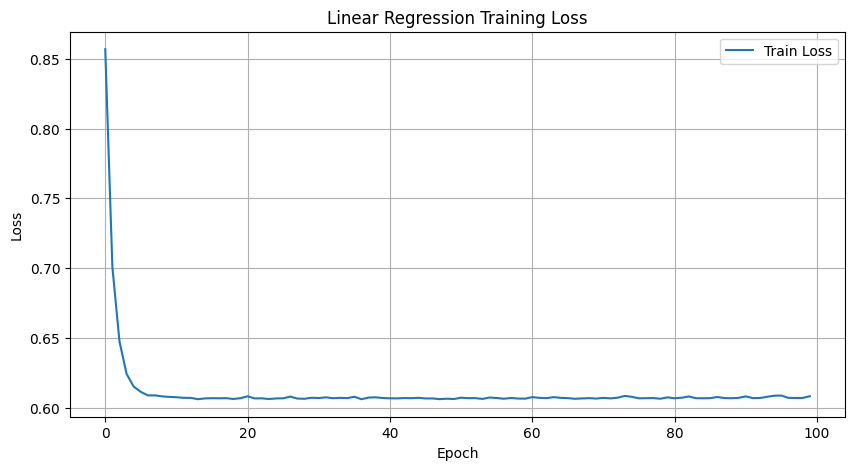

In [84]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_linear, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Regression Training Loss')
plt.legend()
plt.grid(True)
plt.show()

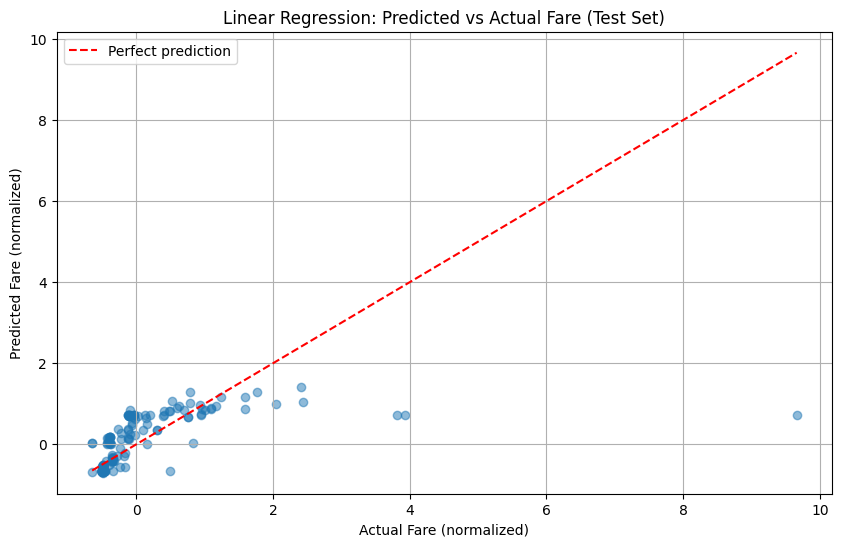

In [85]:
# Collect predictions and actuals on test set
y_test_linear_all = []
y_pred_test_linear_all = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch_linear = X_batch[:, linear_indices]
        y_batch_linear = X_batch[:, fare_idx]
        
        y_pred = linear_model(X_batch_linear)
        
        y_test_linear_all.append(y_batch_linear)
        y_pred_test_linear_all.append(y_pred)

y_test_linear = torch.cat(y_test_linear_all)
y_pred_test_linear = torch.cat(y_pred_test_linear_all)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_linear, y_pred_test_linear, alpha=0.5)
plt.plot([y_test_linear.min(), y_test_linear.max()], 
         [y_test_linear.min(), y_test_linear.max()], 
         'r--', label='Perfect prediction')
plt.xlabel('Actual Fare (normalized)')
plt.ylabel('Predicted Fare (normalized)')
plt.title(f'Linear Regression: Predicted vs Actual Fare (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

### Classification? Multiple outputs

So far we've used **linear regression** to predict continuous values like fare prices. However, the original question for the Titanic dataset is different: predict whether a passenger will **survive** the sinking based on features such as their age, sex, or ticket price.

This is a fundamentally different type of problem:
- **Linear regression**: predicts a continuous real-valued output (e.g., fare price)
- **Classification**: predicts a discrete class label (e.g., survived or died)

While linear regression outputs values in $\mathbb{R}$, classification requires:
1. Multiple outputs constrained to represent probabilities (between 0 and 1) of each class
2. A way to convert these probabilities into discrete class predictions


## Logistic Regression

### The Logistic Regression Model

Logistic regression is similar to linear regression but for classification problems.
The model has two steps:

1. **Linear combination** of all the features:
$$
l = w_{\text{Pclass}} \cdot x_{\text{Pclass}} + w_{\text{Sex}} \cdot x_{\text{Sex}} + w_{\text{Age}} \cdot x_{\text{Age}} + w_{\text{SibSp}} \cdot x_{\text{SibSp}} + w_{\text{Parch}} \cdot x_{\text{Parch}} + a_{\text{Fare}} \cdot x_{\text{Fare}} + b
$$

Features:
- **Pclass**: passenger class (1st, 2nd, or 3rd)
- **Sex**: gender (0=male, 1=female)
- **Age**: age in years
- **SibSp**: number of siblings/spouses aboard
- **Parch**: number of parents/children aboard
- **Fare**: ticket price

Or in compact matrix form:
$$
l = w^T x + b
$$

where $x \in \mathbb{R}^{6}$ is the feature vector, $w \in \mathbb{R}^{6}$ is the weight vector, and $b \in \mathbb{R}$ is the bias.


2. **Sigmoid activation** to get a probability of survival:
$$
\hat{y} = \sigma(l) = \frac{1}{1 + e^{-l}}
$$

The sigmoid function $\sigma$ maps any real number to a value between 0 and 1. We interpret $\hat{y}$ as the probability of survival.

For prediction, we classify as survived if $\hat{y} > 0.5$, and not survived otherwise.

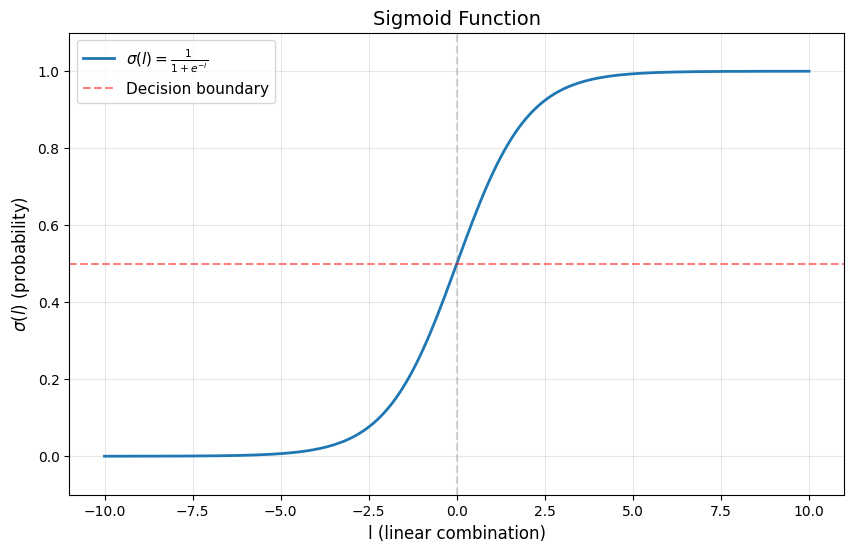

In [86]:
import matplotlib.pyplot as plt

# Create range of values
l = torch.linspace(-10, 10, 200)
sigma = F.sigmoid(l)

plt.figure(figsize=(10, 6))
plt.plot(l, sigma, linewidth=2, label=r'$\sigma(l) = \frac{1}{1+e^{-l}}$')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Decision boundary')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel('l (linear combination)', fontsize=12)
plt.ylabel(r'$\sigma(l)$ (probability)', fontsize=12)
plt.title('Sigmoid Function', fontsize=14)
plt.legend(fontsize=11)
plt.ylim(-0.1, 1.1)
plt.show()

### Model Implementation

In [87]:
# Initialize parameters
num_features = len(feature_names)
w = torch.zeros(num_features, requires_grad=True, dtype=torch.float64)  # weights for all features
b = torch.zeros(1, requires_grad=True, dtype=torch.float64)  # bias

# Logistic regression model
def model(X):
    l = X @ w + b  # linear combination
    return F.sigmoid(l)  # apply sigmoid

print(f"Number of features: {num_features}")
print(f"Features: {feature_names}")

Number of features: 6
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


### Notations

We use the following notation:
- $p(x)$ is the distribution of a random variable $X$
- $p(y)$ is the distribution of a random variable $Y$

$$
\begin{align*}
p(x) &= p(X = x)\\
p(y) &= p(Y = y)\\
p(x, y) &= p(X = x, Y=y)\\
p(y \mid x) &= p(Y = y \mid X = x) 
&= \frac{p(x, y)}{p(x)}
&= \frac{p(x, y)}{\sum_{y} p(x, y)}
\end{align*}
$$

### Loss Function

Our model predicts $\hat{y}_i$, the probability that passenger $i$ survives. For a single observation:
- If $y_i = 1$ (survived), the likelihood of this outcome is $\hat{y}_i = \sigma(w^T x_i + b)$
- If $y_i = 0$ (died), the likelihood of this outcome is $1-\hat{y}_i = (1 - \sigma(w^T x_i + b))$

We can write both cases compactly as: 

$$
p_{w, b}(y_i | x_i) = \hat{y}_i^{y_i} (1-\hat{y}_i)^{1-y_i}
= \sigma(w^T x_i + b)^{y_i} (1 - \sigma(w^T x_i + b))^{1-y_i}
$$
To find the best parameters, we want to **maximize the likelihood** of observing our data. For all $n$ observations (assuming independence):

$$
L = \prod_{i=1}^{n} p_{w, b}(y_i | x_i) = \prod_{i=1}^{n} \hat{y}_i^{y_i} (1-\hat{y}_i)^{1-y_i}
$$

Taking the logarithm (which preserves the maximum) to get the **log-likelihood**:

$$
\ell = \log L = \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]
$$

We just negate and average to get our loss function to minimize.

This is called the **[Binary Cross-Entropy (BCE) loss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)**:

$$
\mathcal{L} = -\frac{1}{n}\sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]
$$

In [88]:
# Binary cross-entropy loss using PyTorch's built-in
loss_fn = torch.nn.BCELoss()

_Note_: What is the difference with [torch.nn.BCEWithLogitsLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)?

### Training with Gradient Descent

We use our usual gradient descent to optimize the parameters using PyTorch's autograd.

In [89]:
# Training parameters
learning_rate = 0.01  # Lower learning rate for mini-batch
num_epochs = 100

# Track loss history
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update parameters (gradient descent step per batch)
        with torch.no_grad():
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad
            w.grad.zero_()
            b.grad.zero_()
        
        epoch_train_loss += loss.item() * len(X_batch)
    
    # Average train loss for epoch
    avg_train_loss = epoch_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_test_loss += loss.item() * len(X_batch)
    
    avg_test_loss = epoch_test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print(f"\nFinal train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")

Epoch 10/100, Train Loss: 0.5289, Test Loss: 0.5723
Epoch 20/100, Train Loss: 0.4748, Test Loss: 0.5400
Epoch 30/100, Train Loss: 0.4527, Test Loss: 0.5290
Epoch 40/100, Train Loss: 0.4413, Test Loss: 0.5245
Epoch 50/100, Train Loss: 0.4350, Test Loss: 0.5229
Epoch 60/100, Train Loss: 0.4313, Test Loss: 0.5223
Epoch 70/100, Train Loss: 0.4289, Test Loss: 0.5223
Epoch 80/100, Train Loss: 0.4273, Test Loss: 0.5226
Epoch 90/100, Train Loss: 0.4263, Test Loss: 0.5226
Epoch 100/100, Train Loss: 0.4256, Test Loss: 0.5229

Final train loss: 0.4256
Final test loss: 0.5229


### Visualize Training Progress

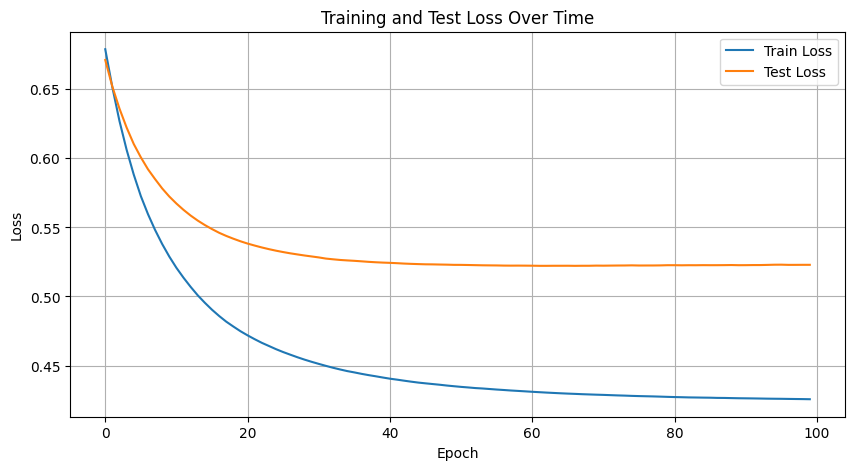

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Model Evaluation

In [91]:
# Evaluate on training set
train_correct = 0
train_total = 0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        y_pred_class = (y_pred > 0.5).double()
        train_correct += (y_pred_class == y_batch).sum().item()
        train_total += len(y_batch)

train_accuracy = train_correct / train_total

# Evaluate on test set
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred_class = (y_pred > 0.5).double()
        test_correct += (y_pred_class == y_batch).sum().item()
        test_total += len(y_batch)

test_accuracy = test_correct / test_total

print(f"Train accuracy: {train_accuracy:.2%}")
print(f"Test accuracy: {test_accuracy:.2%}")

# Print learned parameters
print(f"\nLearned parameters:")
for i, feature in enumerate(feature_names):
    print(f"  w_{feature}: {w[i].item():>7.4f}")
print(f"  b:        {b.item():>7.4f}")

Train accuracy: 80.34%
Test accuracy: 75.98%

Learned parameters:
  w_Pclass: -0.7770
  w_Sex:  1.3015
  w_Age: -0.3759
  w_SibSp: -0.3103
  w_Parch: -0.0873
  w_Fare:  0.2819
  b:        -0.5677


### Baseline: Simple Rule-Based Model

Let's compare our logistic regression to a simple rule: "all women survive, all men die"

In [92]:
# Simple rule: women survive (1), men die (0)
# Get the Sex feature index
sex_idx = feature_names.index("Sex")

# Apply rule on test set
test_correct_simple = 0
test_total_simple = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_simple = (X_batch[:, sex_idx] > 0).double()  # normalized sex > 0 means female
        test_correct_simple += (y_pred_simple == y_batch).sum().item()
        test_total_simple += len(y_batch)

test_accuracy_simple = test_correct_simple / test_total_simple

print(f"Simple rule test accuracy: {test_accuracy_simple:.2%}")
print(f"Logistic regression test accuracy: {test_accuracy:.2%}")

Simple rule test accuracy: 73.74%
Logistic regression test accuracy: 75.98%


### Predict Your Own Survival

Use the trained model to estimate your survival probability:

In [95]:
# Enter your information here
my_pclass = 3        # ticket class (1, 2, or 3)
my_sex = 0           # 0 for male, 1 for female
my_age = 22          # your age in years
my_sibsp = 0         # number of siblings/spouses aboard
my_parch = 0         # number of parents/children aboard
my_fare = 1.0       # ticket price (in 1912 pounds, typical range: 7-500)

# Create feature vector
my_features_dict = {
    "Pclass": my_pclass,
    "Sex": my_sex,
    "Age": my_age,
    "SibSp": my_sibsp,
    "Parch": my_parch,
    "Fare": my_fare
}

# Normalize using the same statistics as training data
my_features_list = []
for i, feature in enumerate(feature_names):
    value = my_features_dict[feature]
    norm_value = (value - X_mean[i].item()) / X_std[i].item()
    my_features_list.append(norm_value)

# Create feature tensor
my_features = torch.tensor(my_features_list, dtype=torch.float64)

# Predict survival probability
with torch.no_grad():
    my_survival_prob = model(my_features).item()
    
print(f"Your profile:")
print(f"  Pclass: {my_pclass}")
print(f"  Sex: {'Female' if my_sex == 1 else 'Male'}")
print(f"  Age: {my_age} years")
print(f"  SibSp: {my_sibsp}")
print(f"  Parch: {my_parch}")
print(f"  Fare: £{my_fare:.2f}")
print(f"\nEstimated survival probability: {my_survival_prob:.1%}")
print(f"Prediction: {'Would survive' if my_survival_prob > 0.5 else 'Would not survive'}")

Your profile:
  Pclass: 3
  Sex: Male
  Age: 22 years
  SibSp: 0
  Parch: 0
  Fare: £1.00

Estimated survival probability: 12.5%
Prediction: Would not survive


## Logistic Regression with PyTorch's nn.Module

Now let's implement the same logistic regression using PyTorch's neural network library.

In [96]:
class LogisticRegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, dtype=torch.float64)
    
    def forward(self, x):
        return F.sigmoid(self.linear(x)).squeeze()

# Create model
model_nn = LogisticRegressionNN(num_features)
print(f"Model: {model_nn}")
print(f"\nInitial parameters:")
print(f"  Weight: {model_nn.linear.weight.data}")
print(f"  Bias: {model_nn.linear.bias.data}")

Model: LogisticRegressionNN(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

Initial parameters:
  Weight: tensor([[-0.3171,  0.3015, -0.2491, -0.1215,  0.2484, -0.2087]],
       dtype=torch.float64)
  Bias: tensor([-0.4025], dtype=torch.float64)


In [ ]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model_nn.parameters(), lr=0.01)

# Training
num_epochs_nn = 100
train_losses_nn = []
test_losses_nn = []

for epoch in range(num_epochs_nn):
    # Training phase
    model_nn.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model_nn(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * len(X_batch)
    
    avg_train_loss = epoch_train_loss / len(train_dataset)
    train_losses_nn.append(avg_train_loss)
    
    # Evaluation phase
    model_nn.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model_nn(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_test_loss += loss.item() * len(X_batch)
    
    avg_test_loss = epoch_test_loss / len(test_dataset)
    test_losses_nn.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs_nn}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print(f"\nFinal train loss: {train_losses_nn[-1]:.4f}")
print(f"Final test loss: {test_losses_nn[-1]:.4f}")

Epoch 10/100, Train Loss: 0.4841, Test Loss: 0.5343
Epoch 20/100, Train Loss: 0.4546, Test Loss: 0.5229
Epoch 30/100, Train Loss: 0.4414, Test Loss: 0.5192
Epoch 40/100, Train Loss: 0.4345, Test Loss: 0.5184
Epoch 50/100, Train Loss: 0.4305, Test Loss: 0.5183
Epoch 60/100, Train Loss: 0.4281, Test Loss: 0.5190
Epoch 70/100, Train Loss: 0.4266, Test Loss: 0.5193
Epoch 80/100, Train Loss: 0.4257, Test Loss: 0.5199
Epoch 90/100, Train Loss: 0.4251, Test Loss: 0.5201
Epoch 100/100, Train Loss: 0.4247, Test Loss: 0.5208

Final train loss: 0.4247
Final test loss: 0.5208


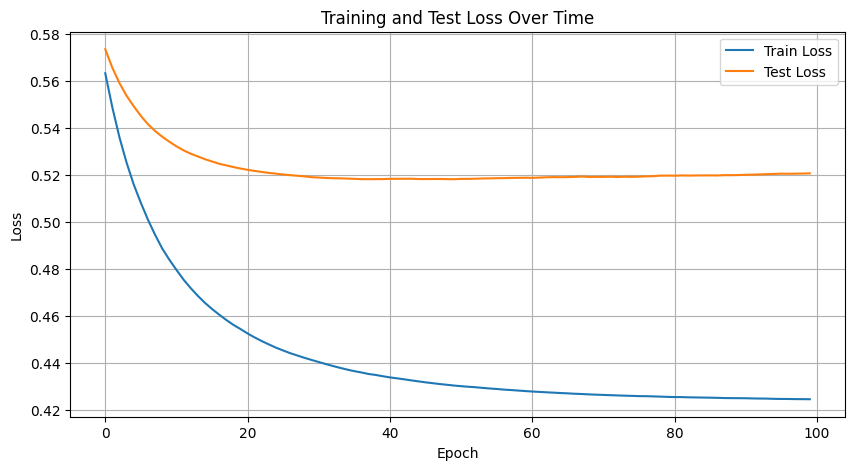

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_nn, label='Train Loss')
plt.plot(test_losses_nn, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# Evaluate nn.Module model
model_nn.eval()
train_correct_nn = 0
train_total_nn = 0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_pred = model_nn(X_batch)
        y_pred_class = (y_pred > 0.5).double()
        train_correct_nn += (y_pred_class == y_batch).sum().item()
        train_total_nn += len(y_batch)

test_correct_nn = 0
test_total_nn = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model_nn(X_batch)
        y_pred_class = (y_pred > 0.5).double()
        test_correct_nn += (y_pred_class == y_batch).sum().item()
        test_total_nn += len(y_batch)

train_accuracy_nn = train_correct_nn / train_total_nn
test_accuracy_nn = test_correct_nn / test_total_nn

print(f"Train accuracy: {train_accuracy_nn:.2%}")
print(f"Test accuracy: {test_accuracy_nn:.2%}")

print(f"\nLearned parameters (nn.Module):")
print(f"  Weight: {model_nn.linear.weight.data.squeeze()}")
print(f"  Bias: {model_nn.linear.bias.data}")

Train accuracy: 80.90%
Test accuracy: 74.86%

Learned parameters (nn.Module):
  Weight: tensor([-0.8621,  1.3140, -0.4134, -0.3279, -0.0510,  0.1791],
       dtype=torch.float64)
  Bias: tensor([-0.5922], dtype=torch.float64)


## Softmax Regression (Multinomial Logistic Regression)

So far we've seen **logistic regression** for binary classification (2 classes). Now let's extend this to **multiple classes**.

### Probabilistic Model

For $K$ classes, we want to predict the probability distribution over all classes given input features $x$:

$$
p(y = k \mid x) \quad \text{for } k = 0, 1, \ldots, K-1
$$

The model learns a separate linear function for each class:

$$
l_k = w_k^T x + b_k \quad \text{for each class } k
$$

where:
- $w_k \in \mathbb{R}^d$ is the weight vector for class $k$
- $b_k \in \mathbb{R}$ is the bias for class $k$
- $x \in \mathbb{R}^d$ is the input feature vector (column vector)
- $l_k \in \mathbb{R}$ is the logit (unnormalized log-probability) for class $k$

**Matrix form**: Stacking all $K$ weight vectors into a matrix $W \in \mathbb{R}^{K \times d}$ where each row is $w_k^T$:

$$
l = Wx + b
$$

where:
- $W \in \mathbb{R}^{K \times d}$ contains all weight vectors (one row per class)
- $x \in \mathbb{R}^d$ is the input feature vector (column vector)
- $b \in \mathbb{R}^K$ contains all biases (one per class)
- $l \in \mathbb{R}^K$ contains all logits (one per class)

### The Softmax Function

To convert these logits $l_k$ into valid probabilities, we need:
1. All probabilities to be positive: $p(y = k \mid x) \geq 0$
2. All probabilities to sum to 1: $\sum_{k=0}^{K-1} p(y = k \mid x) = 1$

The **softmax function** achieves both properties:

$$
p(y = k \mid x) = \text{softmax}(l)_k = \frac{e^{l_k}}{\sum_{j=0}^{K-1} e^{l_j}}
$$

Intuitively:
- The exponential $e^{l_k}$ ensures positivity
- The normalization by $\sum_{j=0}^{K-1} e^{l_j}$ ensures probabilities sum to 1
- Larger logits get larger probabilities

**Special case**: For binary classification ($K=2$), the softmax reduces to the sigmoid function used in logistic regression.

**Proof**: For two classes with logits $l_0$ and $l_1$:

$$
\begin{align*}
p(y=1 \mid x) &= \frac{e^{l_1}}{e^{l_0} + e^{l_1}} \\
&= \frac{e^{l_1}}{e^{l_0} + e^{l_1}} \cdot \frac{e^{-l_0}}{e^{-l_0}} \quad \text{(multiply by } e^{-l_0}\text{)} \\
&= \frac{e^{l_1 - l_0}}{1 + e^{l_1 - l_0}} \\
&= \frac{1}{1 + e^{-(l_1 - l_0)}} \\
&= \sigma(l_1 - l_0)
\end{align*}
$$

_Note_: the **Log-Sum-Exp trick**: Computing $e^{l_k}$ can cause overflow for large values. The **log-sum-exp trick** uses the mathematically equivalent but numerically stable form:

$$
\text{softmax}(l)_k = \frac{e^{l_k - \max(l)}}{\sum_{j=0}^{K-1} e^{l_j - \max(l)}}
$$

By subtracting $\max(l)$ from all logits before exponentiating, we ensure that the largest exponent is 0, preventing overflow. PyTorch's `F.softmax()` and `F.log_softmax()` apply this trick automatically.

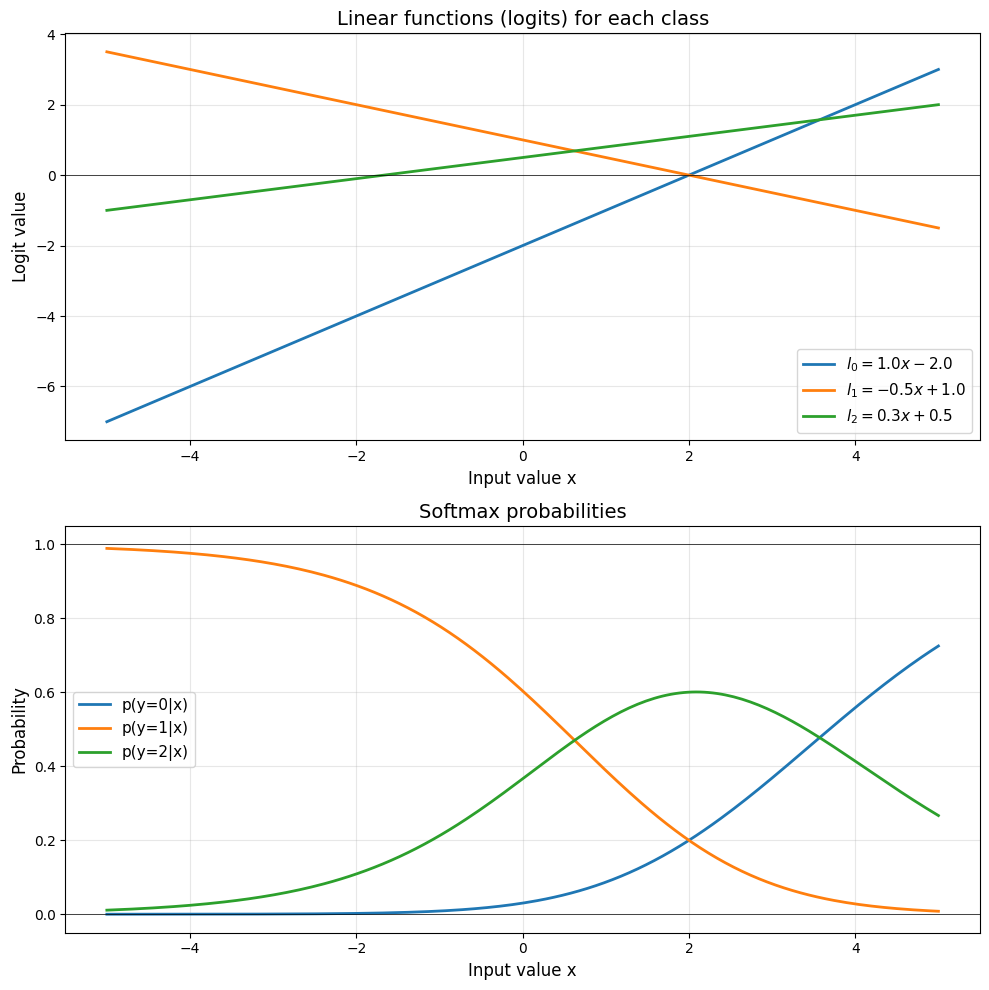

In [100]:
# Visualize softmax function with 3 classes
import numpy as np

# Create varying input values
x = np.linspace(-5, 5, 200)

# Define different weight vectors for 3 classes
# Each class has its own linear function l_k = w_k * x + b_k
w0, b0 = 1.0, -2.0   # Class 0: l_0 = 1.0*x - 2.0
w1, b1 = -0.5, 1.0   # Class 1: l_1 = -0.5*x + 1.0
w2, b2 = 0.3, 0.5    # Class 2: l_2 = 0.3*x + 0.5

# Compute logits for each class
l0 = w0 * x + b0
l1 = w1 * x + b1
l2 = w2 * x + b2

# Compute softmax probabilities
exp_l0 = np.exp(l0)
exp_l1 = np.exp(l1)
exp_l2 = np.exp(l2)
Z = exp_l0 + exp_l1 + exp_l2

p0 = exp_l0 / Z
p1 = exp_l1 / Z
p2 = exp_l2 / Z

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Top plot: Raw logits
ax1.plot(x, l0, label=r'$l_0 = 1.0x - 2.0$', linewidth=2)
ax1.plot(x, l1, label=r'$l_1 = -0.5x + 1.0$', linewidth=2)
ax1.plot(x, l2, label=r'$l_2 = 0.3x + 0.5$', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Input value x', fontsize=12)
ax1.set_ylabel('Logit value', fontsize=12)
ax1.set_title('Linear functions (logits) for each class', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Softmax probabilities
ax2.plot(x, p0, label='p(y=0|x)', linewidth=2)
ax2.plot(x, p1, label='p(y=1|x)', linewidth=2)
ax2.plot(x, p2, label='p(y=2|x)', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='k', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Input value x', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Softmax probabilities', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

### Loss Function: Cross-Entropy

For softmax regression, the **negative log-likelihood (NLL)** loss is:

$$
\mathcal{L} = -\frac{1}{n} \sum_{i=1}^{n} \log p(y_i \mid x_i) = -\frac{1}{n} \sum_{i=1}^{n} \log \text{softmax}(W x_i + b)_{y_i}
$$

This can also be written using indicator functions (double sum over samples and classes):

$$
\mathcal{L} = -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=0}^{K-1} \mathbb{1}_{y_i = k} \log p(y_i = k \mid x_i)
$$

where $\mathbb{1}_{y_i = k} = 1$ if $y_i = k$, and $0$ otherwise.

### PyTorch Implementation

PyTorch provides two equivalent ways to compute this loss:

**1. Two-step approach:**
- Apply `F.log_softmax()` to get log-probabilities
- Use `F.nll_loss()` or `nn.NLLLoss()` to compute the negative log-likelihood

**2. Combined approach:**
- Use `F.cross_entropy()` or `nn.CrossEntropyLoss()`
- This combines `log_softmax` + `nll_loss` in one numerically stable operation

**Important**: `nn.CrossEntropyLoss()` expects:
- **Input**: raw logits (unnormalized scores) of shape `[batch_size, num_classes]`
- **Target**: class indices (integers) of shape `[batch_size]`


In [101]:
logsoftmax = nn.LogSoftmax(dim=1)
nllLoss = nn.NLLLoss()
crossEntropyLoss = nn.CrossEntropyLoss()

C = 8
input = torch.randn(3,C,4,5)
target = torch.empty(3,4,5, dtype=torch.long).random_(0,C)
assert torch.isclose(nllLoss(logsoftmax(input),target), crossEntropyLoss(input,target))

### Classification with argmax

For classification, we predict the class with highest probability:

$$
\hat{y} = \arg\max_k p(y = k \mid x) = \arg\max_k l_k
$$

Since softmax is monotonic, we can directly use `argmax` on the logits without computing softmax:

```python
ceLoss = nn.CrossEntropyLoss()

# During training
logits = model(x)  # shape [batch_size, num_classes]
loss = ceLoss(logits, targets)

# During inference
predictions = logits.argmax(dim=1)
```

### Summary: Loss functions

| Function | Input | Output | Use case |
|----------|-------|--------|----------|
| [`nn.MSELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) | Raw predictions | Scalar loss | Regression tasks |
| [`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) | Probabilities (after sigmoid) | Scalar loss | Binary classification |
| [`nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) | Log-probabilities (after `log_softmax`) | Scalar loss |  multi-class classification when you already have log-probabilities |
| [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) | Raw logits | Scalar loss | multi-class classification |

## Your turn!

Build an MLP for classification on CFAR.